# Synthetic Data For Future Forecasting
In this notebook, we will look at extrapolating past trends that are easy to predict to construct a dataframe that will be fed into the XGBoost model to look at future trends in daily minimums and maximums.
We will use exponential smoothing to project into the future as it its relatively simple and the projections we want to make are fairly straightforward.

In [9]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, Holt

sns.set_theme()

In [3]:
# read in data
df = pd.read_csv('../data/raw/all_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index()
df.drop(['temp_mean', 'units', 'cum_units', 'output'], axis=1, inplace=True)
df

,demand_min,demand_max,temp_min,temp_max,cum_output,population
datetime,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,3.036293e+04,7.144292e+06
2010-01-02,6112.73,9326.64,21.6,29.4,3.049634e+04,7.144495e+06
2010-01-03,6014.91,8277.85,17.9,21.5,3.062975e+04,7.144699e+06
2010-01-04,6023.79,9522.30,17.9,23.9,3.076316e+04,7.144902e+06
2010-01-05,6287.12,10728.72,15.4,27.7,3.089657e+04,7.145106e+06
...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,3.490182e+06,8.093864e+06
2020-11-27,6152.19,10173.41,18.6,26.3,3.493903e+06,8.093863e+06
2020-11-28,6284.18,12421.83,18.3,40.4,3.497624e+06,8.093862e+06


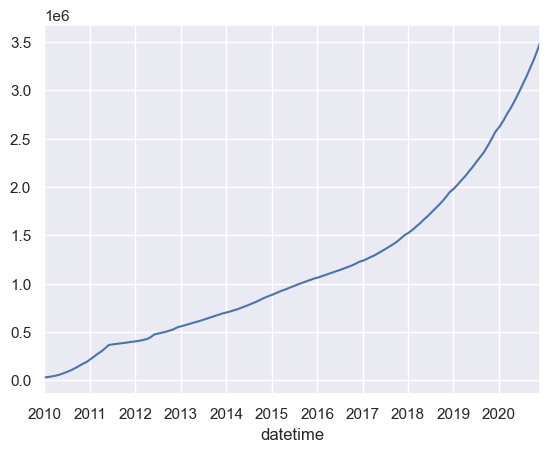

In [5]:
df['cum_output'].plot()
plt.show()

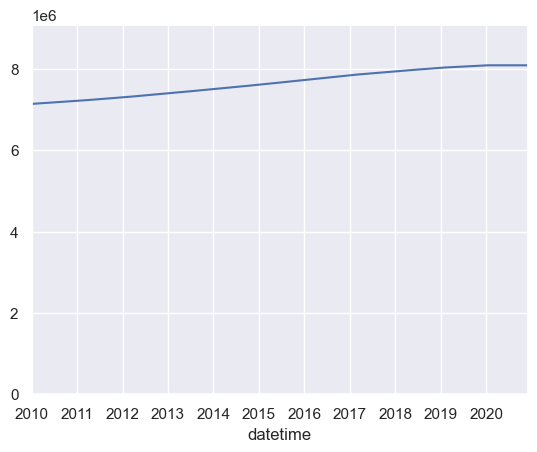

In [8]:
df['population'].plot(ylim=[0,(df['population'].max()+10**6)])
plt.show()

C:\Users\sambo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sambo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


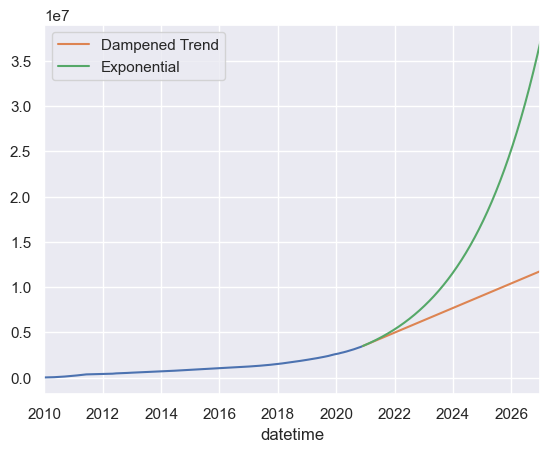

In [75]:
fit_output1 = Holt(df['cum_output'], damped_trend=True, initialization_method="estimated").fit(damping_trend=1)
fcast1_output = fit_output1.forecast(365*6+32).rename("Dampened Trend")

fit_output2 = Holt(df['cum_output'], exponential=True, initialization_method="estimated").fit()
fcast2_output = fit_output2.forecast(365*6+32).rename("Exponential")

ax = df['cum_output'].plot()
fcast1_output.plot(ax=ax, legend=True)
fcast2_output.plot(ax=ax, legend=True)
plt.show()

It's estimated that currently only ~25% of households have solar in NSW. Panels get cheaper and technology improves, the exponential projection might be more accurate.

In [83]:
fcast2_output.rename('cum_output', inplace=True)
fcast2_output

2020-12-01    3.508790e+06
2020-12-02    3.512519e+06
2020-12-03    3.516251e+06
2020-12-04    3.519988e+06
2020-12-05    3.523728e+06
                  ...     
2026-12-27    3.696424e+07
2026-12-28    3.700352e+07
2026-12-29    3.704284e+07
2026-12-30    3.708221e+07
2026-12-31    3.712161e+07
Freq: D, Name: cum_output, Length: 2222, dtype: float64

C:\Users\sambo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


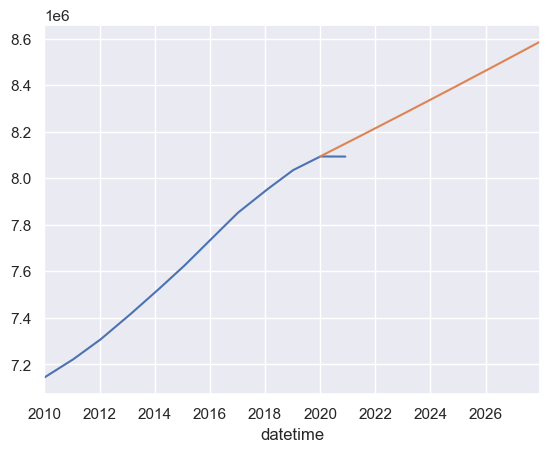

In [50]:
# Suspicious that data from ABS from 2021 is not accurate may need to make projections from 2020
pop_mask = df.index < '2020-01-01'
pop_df = df[pop_mask]

fit_pop = Holt(pop_df['population'], exponential=True, initialization_method="estimated").fit()
fcast_pop = fit_pop.forecast(365*8).rename("Exponential")

ax = df['population'].plot()
fcast_pop.plot(ax=ax)
plt.show()

In [84]:
fcast_pop.rename('population', inplace=True)
fcast_pop

2020-01-01    8.094317e+06
2020-01-02    8.094481e+06
2020-01-03    8.094646e+06
2020-01-04    8.094810e+06
2020-01-05    8.094975e+06
                  ...     
2027-12-25    8.588080e+06
2027-12-26    8.588254e+06
2027-12-27    8.588429e+06
2027-12-28    8.588603e+06
2027-12-29    8.588778e+06
Freq: D, Name: population, Length: 2920, dtype: float64

In [49]:
# Monthly averages for Sydney from BOM http://www.bom.gov.au/climate/averages/tables/cw_066062.shtml
syd_av_max_temps = {'January':26,
                    'February':25.8,
                    'March':24.8,
                    'April':22.5,
                    'May':19.5,
                    'June':17,
                    'July':16.4,
                    'August':17.9,
                    'September':20.1,
                    'October':22.2,
                    'November':23.7,
                    'December':25.2,
}
syd_av_min_temps = {'January':18.8,
                    'February':18.9,
                    'March':17.6,
                    'April':14.8,
                    'May':11.6,
                    'June':9.3,
                    'July':8.1,
                    'August':9,
                    'September':11.1,
                    'October':13.6,
                    'November':15.7,
                    'December':17.6,
}

In [124]:
df_future = pd.DataFrame(index=pd.date_range(start='2021-01-01', end='2026-12-31', freq='D'))
df_future = df_future.merge(fcast2_output, left_index=True, right_index=True)
df_future = df_future.merge(fcast_pop, left_index=True, right_index=True)

In [125]:
df_future['temp_max'] = np.nan
df_future['temp_min'] = np.nan
for i, month in enumerate(syd_av_max_temps):
    df_future.loc[df_future.index.month == (i+1), 'temp_max'] = syd_av_max_temps[month]
    df_future.loc[df_future.index.month == (i+1), 'temp_min'] = syd_av_min_temps[month]
df_future.index.name = 'datetime'

In [126]:
df_future

,cum_output,population,temp_max,temp_min
datetime,,,,
2021-01-01,3.626240e+06,8.154720e+06,26.0,18.8
2021-01-02,3.630094e+06,8.154885e+06,26.0,18.8
2021-01-03,3.633951e+06,8.155051e+06,26.0,18.8
2021-01-04,3.637813e+06,8.155216e+06,26.0,18.8
2021-01-05,3.641679e+06,8.155382e+06,26.0,18.8
...,...,...,...,...
2026-12-27,3.696424e+07,8.524987e+06,25.2,17.6
2026-12-28,3.700352e+07,8.525160e+06,25.2,17.6
2026-12-29,3.704284e+07,8.525333e+06,25.2,17.6


In [127]:
df_future.to_csv('../data/raw/future_projections.csv')